In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# dataset path
stat_image_training = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/training/input/"
masks_image_training = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/training/output/"

In [108]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import normalize
import random
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

In [76]:
SIZE = 256
stat_image_dataset = [] 
masks_image_dataset = [] 

In [77]:
images = os.listdir(stat_image_training)
for i, image_name in enumerate(images): 
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(stat_image_training+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        stat_image_dataset.append(np.array(image))


In [78]:
masks = os.listdir(masks_image_training)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(masks_image_training+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        masks_image_dataset.append(np.array(image))

In [82]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(stat_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
masks_dataset = np.expand_dims((np.array(masks_image_dataset)),3) /255.


In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, masks_dataset, test_size = 0.30, random_state = 0)

188


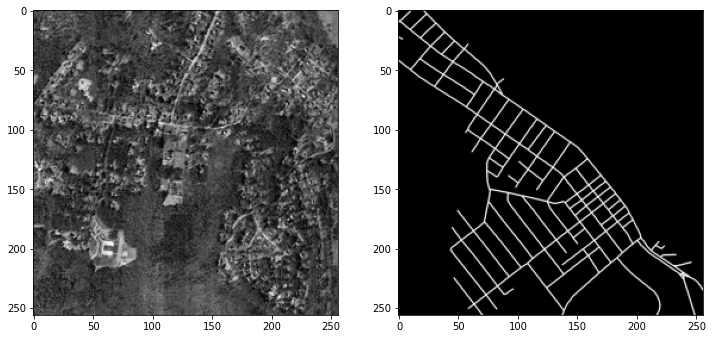

In [98]:
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [102]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [109]:

# Now defining Unet 
def roadextract_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

    model.summary()
    
    return model

In [110]:
def get_jacard_model():
    return roadextract_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [111]:
model_roadextract_jacard = get_jacard_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 16  160         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_24 (Dropout)           (None, 256, 256, 16  0           ['conv2d_58[0][0]']              
                                )                                                           

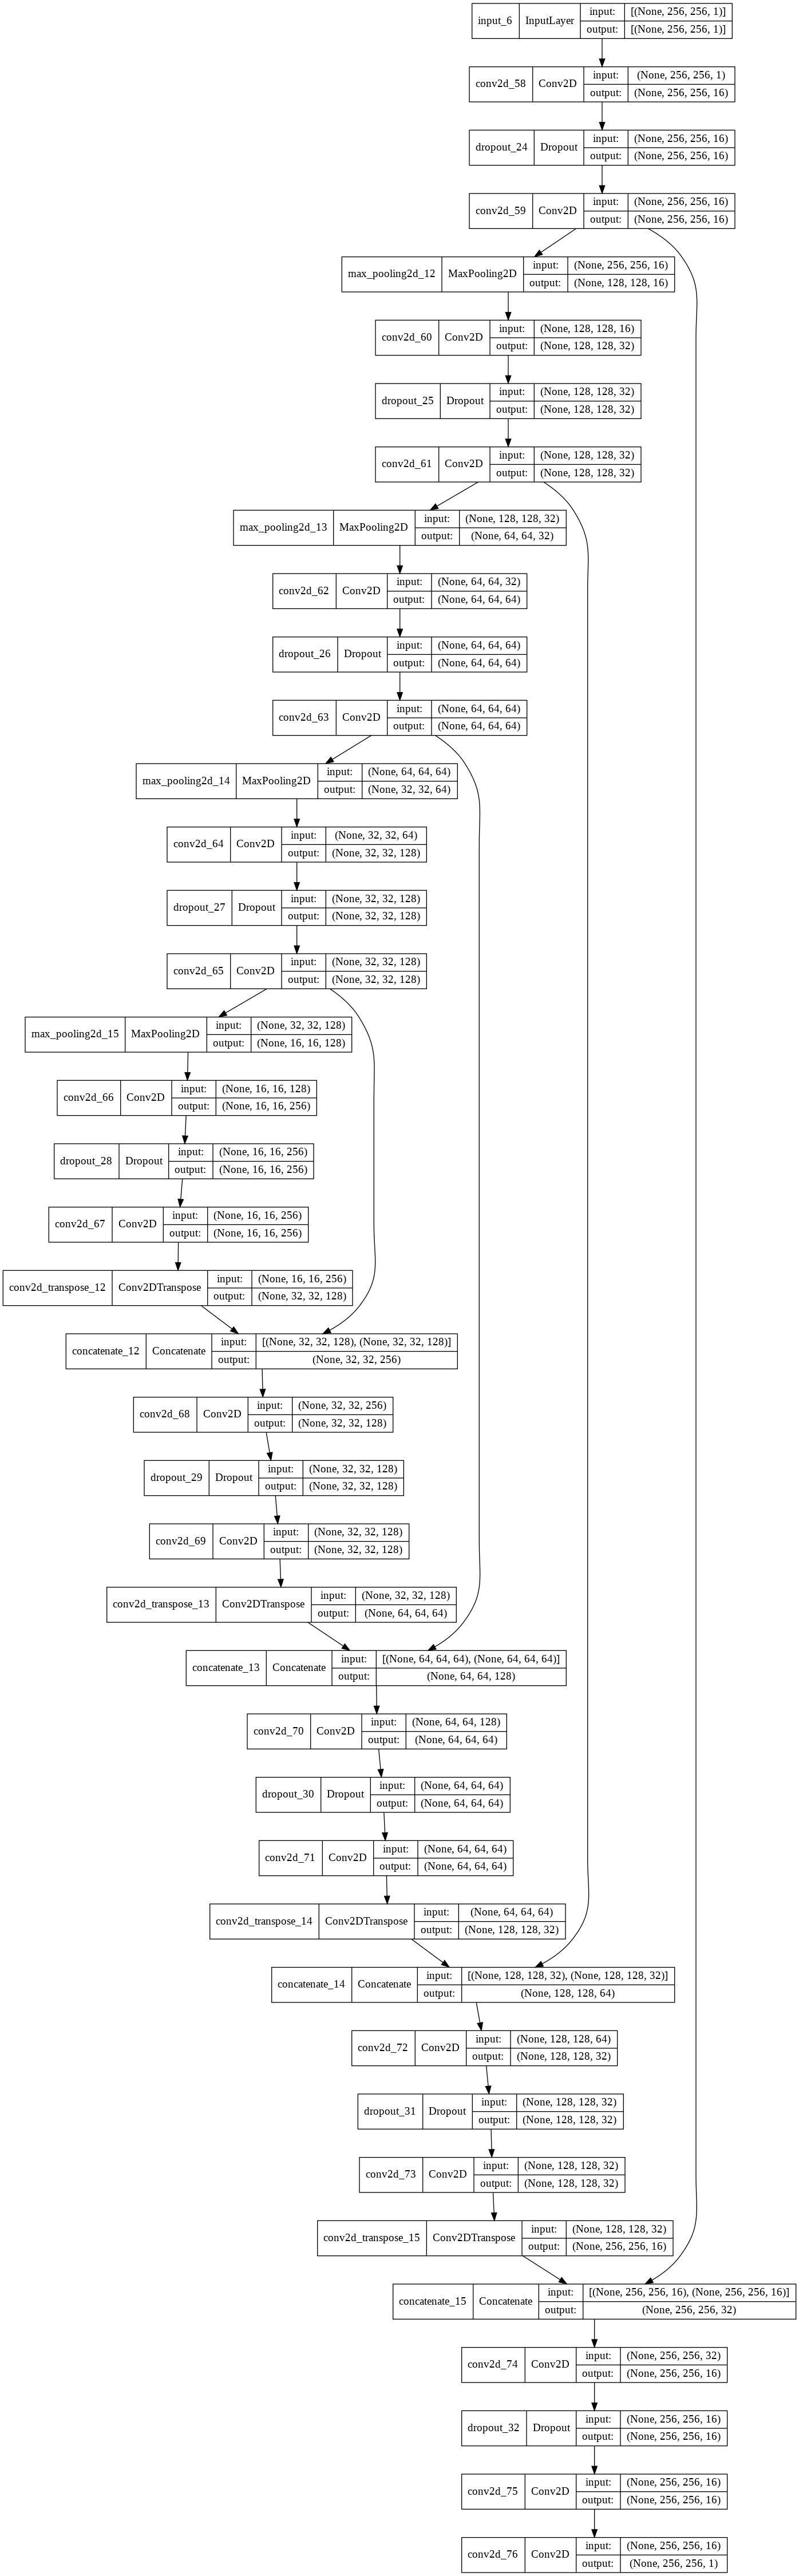

In [112]:
from keras.utils.vis_utils import plot_model
plot_model(model_roadextract_jacard, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [113]:
model_jacard = model_roadextract_jacard.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
36/36 [==============================] - 446s 12s/step - loss: -0.0534 - jacard_coef: 0.0536 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 2/10
36/36 [==============================] - 440s 12s/step - loss: -0.0537 - jacard_coef: 0.0539 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 3/10
36/36 [==============================] - 434s 12s/step - loss: -0.0537 - jacard_coef: 0.0539 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 4/10
36/36 [==============================] - 426s 12s/step - loss: -0.0537 - jacard_coef: 0.0539 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 5/10
36/36 [==============================] - 427s 12s/step - loss: -0.0537 - jacard_coef: 0.0539 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 6/10
36/36 [==============================] - 428s 12s/step - loss: -0.0537 - jacard_coef: 0.0539 - val_loss: -0.0551 - val_jacard_coef: 0.0553
Epoch 7/10
36/36 [==============================] - 427s 12s/step - loss: -0.0537 - jacard_coef: 0.0

In [115]:
model_roadextract_jacard.save('model_roadextract_jacard.hdf5')

In [116]:
# evaluate model
_, acc = model_roadextract_jacard.evaluate(X_test, y_test)
print("Accuracy of Jacard Model is = ", (acc * 100.0), "%")


8/8 [==============================] - 37s 5s/step - loss: -0.0551 - jacard_coef: 0.0555
Accuracy of Jacard Model is =  5.551376938819885 %


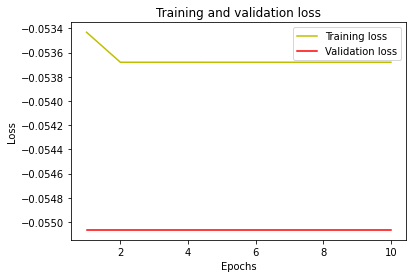

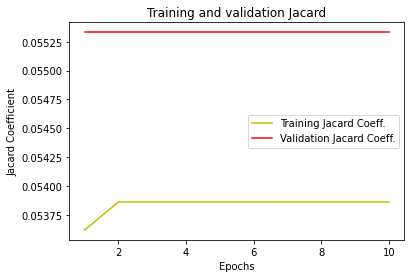

In [117]:
#plot the training and validation accuracy and loss at each epoch
loss = model_jacard.history['loss']
val_loss = model_jacard.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

jc = model_jacard.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = model_jacard.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()


In [118]:
#IOU
y_pred=model_roadextract_jacard.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.11293849472172005


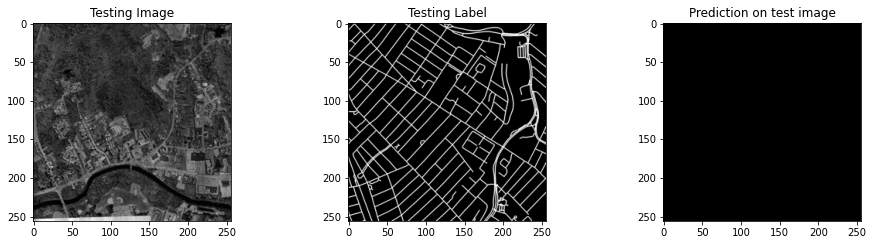

In [138]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[2]
ground_truth=y_test[2]
test_img_norm=test_img[:,:,0]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model_roadextract_jacard.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
